<h1><center>OSIC Pulmonary Fibrosis Progression</center></h1>

### 1.Introduction
Pulmonary fibrosis or scarring in the lungs is a family of more than 200 different lung diseases that are very similar. Over time, the scar tissue blocks the movement of oxygen from inside the tiny air sacs in the lungs into the bloodstream. There are five main categories of identifiable causes of pulmonary fibrosis: 
* drug-induced
* radiation-induced
* environmental
* autoimmune
* occupational

With all this, it can still be very challenging for doctors to determine the exact cause of a pulmonary fibrosis case. A pulmonary fibrosis case of unknown cause is called "idiopathic". With no known cure, current methods make fibrotic lung diseases difficult to treat even with access to a chest CT scan. On top of the disease having no cure, the prognosis of outcomes range from long-term stability to rapid deterioration, with doctors having no accurate way to determine where exactly a patient falls on that spectrum.<br>
### 2.Problem statement
With the use of neural networks this notebook aims to predict a patient's severity of decline in lung function based on a CT scan of their lungs, and several other data which we will describe later. Lung function is being measured with the help of a spirometer, which measures the volume of air inhaled and exhaled. This value is called a FVC, which stands for Forced Vital Capacity.<br>
### 3.Data
* train.csv - the training set, contains full history of clinical information
* test.csv - the test set, contains only the baseline measurement
* train/ - contains the training patients' baseline CT scan in DICOM format
* test/ - contains the test patients' baseline CT scan in DICOM format
* sample_submission.csv - demonstrates the submission format

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objs as go

In [3]:
train_df = pd.read_csv('input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('input/osic-pulmonary-fibrosis-progression/test.csv')

In [4]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
test_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


|Column name|Meaning|
|:------------:|:-----------:|
|Patient|a unique Id for each patient (also the name of the patient's DICOM folder)|
|Weeks|the relative number of weeks pre/post the baseline CT (may be negative)|
|FVC|the recorded lung capacity in ml|
|Percent|a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics|
|Age|age of patient|
|Sex|sex of patient|
|SmokingStatus|smoking status of patient|

In [6]:
## Exploring the data
print('Shape of Training data: ', train_df.shape)
print('Shape of Test data: ', test_df.shape)

Shape of Training data:  (1549, 7)
Shape of Test data:  (5, 7)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non-null      int64  
 5   Sex            5 non-null      object 
 6   SmokingStatus  5 non-null      object 
dtypes: float64(1), int64(3), object(3)
memory usage: 408.0+ bytes


In [9]:
print(f"Number of unique ids are {train_df['Patient'].value_counts().shape[0]} ")

Number of unique ids are 176 


In [10]:
new_df = train_df.groupby([train_df.Patient,train_df.Age,train_df.Sex, train_df.SmokingStatus])['Patient'].count()
new_df.index = new_df.index.set_names(['id','Age','Sex','SmokingStatus'])
new_df = new_df.reset_index()
new_df.rename(columns = {'Patient': 'freq'},inplace = True)
new_df.head()

,id,Age,Sex,SmokingStatus,freq
0,ID00007637202177411956430,79,Male,Ex-smoker,9
1,ID00009637202177434476278,69,Male,Ex-smoker,9
2,ID00010637202177584971671,60,Male,Ex-smoker,9
3,ID00011637202177653955184,72,Male,Ex-smoker,9
4,ID00012637202177665765362,65,Male,Never smoked,9


In [11]:
fig = px.bar(new_df, x='id',y ='freq',color='freq')
fig.update_layout(xaxis={'categoryorder':'total ascending'},title='No. of observations for each patient')
fig.update_xaxes(showticklabels=False)
fig.show()

In [12]:
fig = px.histogram(new_df, x='Age',nbins = 42)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title = 'Distribution of Age for unique patients')
fig.show()

In [13]:
fig = px.histogram(new_df, x='Sex')
fig.update_traces(marker_color='rgb(202,158,225)', marker_line_color='rgb(48,8,107)',
                 marker_line_width=2, opacity=0.8)
fig.update_layout(title = 'Distribution of Sex for unique patients')
fig.show()

In [14]:
fig = px.histogram(new_df, x='SmokingStatus')
fig.update_traces(marker_color='rgb(202,225,158)', marker_line_color='rgb(48,107,8)',
                 marker_line_width=2, opacity=0.8)
fig.update_layout(title = 'Distribution of SmokingStatus for unique patients')
fig.show()

In [15]:
fig = px.histogram(new_df, x='SmokingStatus',color = 'Sex')
fig.update_traces(marker_line_color='black',marker_line_width=2, opacity=0.85)
fig.update_layout(title = 'Distribution of SmokingStatus for unique patients')
fig.show()

### 3.DICOM
For every patient there is a folder named with their unique ids. These folders contain images from a medical scan, like a CT scan and information about the patient. It is important to understand that each folder has a number of images, but they are all from the same scan, carried out on the same day. CT scans are pictures that slice from the beginning of the torso up to the neck. FVC measurements were carried out before, after and sometimes on the day of the CT scan. These images are called DICOM files. DICOM stands for "Digital Imaging and Communications in Medicine" and has two parts: the header and the dataset. The header contains information on the encapsulated dataset. It consists of a File Preamble, a DICOM prefix, and the File Meta Elements.

In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from tqdm import tqdm

from PIL import Image

In [2]:
Path = "input/osic-pulmonary-fibrosis-progression"
df_train= pd.read_csv(f"{Path}/train.csv")
df_train.drop_duplicates(keep=False, inplace=True,subset=['Patient','Weeks'])
df_test= pd.read_csv(f"{Path}/test.csv")
Patient_list= df_train["Patient"].unique()

100%|██████████| 71/71 [00:03<00:00, 21.85it/s]


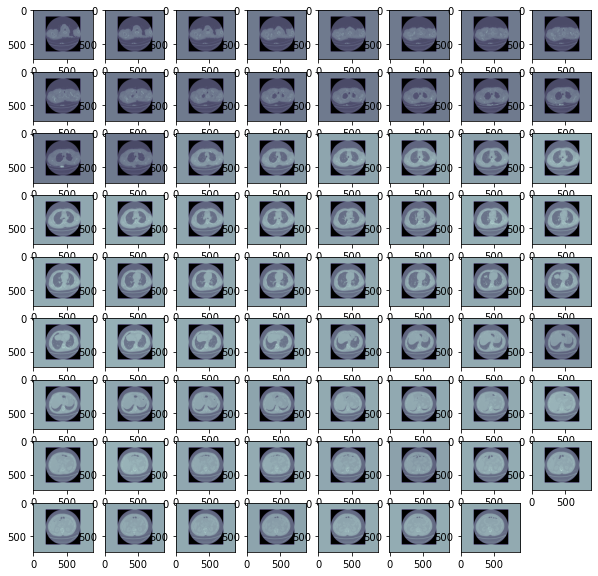

In [3]:
def getDcms(patient,type):
    image_dir = f"{Path}/{type}/{patient}"
    fig=plt.figure(figsize=(10,10))
    image_list = os.listdir(image_dir)
    columns = int(np.sqrt(len(image_list)))
    rows = columns+1
    dcms=[]
    for i in tqdm(range(1, len(image_list) +1)):
        ds = pydicom.dcmread(image_dir + "/" + str(i) + ".dcm")
        dcms.append(ds.pixel_array)
        fig.add_subplot(rows,columns,i)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    return dcms

list=getDcms(Patient_list[50],"train" )

In [4]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [5]:
def get_Weeks_Dcms(type):
    fig=plt.figure(figsize=(10,10))
    dcms=[]
    plist=[]
    wlist=[]
    for p in tqdm(Patient_list):
        image_dir = f"{Path}/{type}/{p}"
        week=df_train[df_train["Patient"]==p]["Weeks"]
        for w in week:
            try:
                ds = pydicom.dcmread(image_dir + "/" + str(w) + ".dcm")
                dcms.append(ds.pixel_array)
                plist.append(p)
                wlist.append(w)
            except:
                pass
    data = pd.DataFrame({"Patient":plist,"Weeks":wlist})        
    return dcms,data

In [6]:
x_train,train_data=get_Weeks_Dcms("train")

100%|██████████| 176/176 [00:20<00:00,  8.61it/s]


<Figure size 720x720 with 0 Axes>

In [7]:
for i in range(0,len(x_train)):
    im = Image.fromarray(x_train[i])
    im = im.resize((128,128),resample=Image.NEAREST) 
    x_train[i] = np.array(im).reshape((128,128,1))
    #x_train[i] = np.array(im)
    
x_train=np.array(x_train)
train_data = pd.merge(train_data,df_train, how="left", on=['Patient',"Weeks"])

In [8]:
train_data["Sex"]=train_data["Sex"].astype("category").cat.codes
train_data["SmokingStatus"]=train_data["SmokingStatus"].astype("category").cat.codes

 <h3><font color=red>Min-Max Normalization </font> <h3>

In [9]:
train_data["Weeks"]=(train_data['Weeks'] - train_data['Weeks'].min() ) / ( train_data['Weeks'].max() - train_data['Weeks'].min() )
train_data["Percent"]=(train_data['Percent'] - train_data['Percent'].min() ) / ( train_data['Age'].max() - train_data['Percent'].min() )
train_data["Age"]=(train_data['Age'] - train_data['Age'].min() ) / ( train_data['Age'].max() - train_data['Age'].min() )

In [10]:
train_data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,0.034783,2214,0.453881,0.769231,1,1
1,ID00007637202177411956430,0.052174,2061,0.388762,0.769231,1,1
2,ID00007637202177411956430,0.069565,2144,0.424088,0.769231,1,1
3,ID00007637202177411956430,0.086957,2069,0.392167,0.769231,1,1
4,ID00007637202177411956430,0.139130,2101,0.405786,0.769231,1,1
...,...,...,...,...,...,...,...
1226,ID00426637202313170790466,0.104348,2712,0.637948,0.615385,1,2
1227,ID00426637202313170790466,0.156522,2978,0.748427,0.615385,1,2
1228,ID00426637202313170790466,0.260870,2908,0.719354,0.615385,1,2
1229,ID00426637202313170790466,0.365217,2975,0.747181,0.615385,1,2


In [11]:
y=train_data["FVC"].values
feature=train_data[['Weeks','Percent','Age','Sex',"SmokingStatus"]].values

 <h3><font color=red>Min-Max Normalization </font> <h3>

In [12]:
x_min = np.min(x_train)
x_max = np.max(x_train)
xs = x_train - x_min / (x_max - x_min)

In [13]:
y.shape,feature.shape,xs.shape,x_train.shape

((1231,), (1231, 5), (1231, 128, 128, 1), (1231, 128, 128, 1))

In [14]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

![jupyter](./Laplace.png)
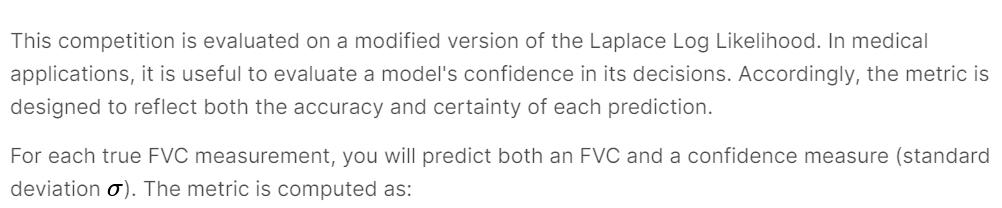

![jupyter](./metric.png)
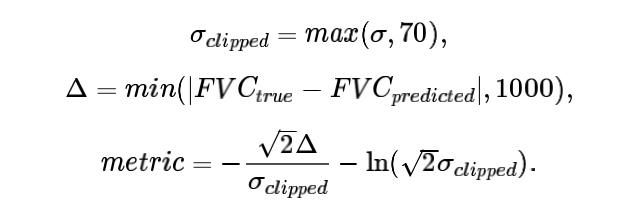

In [15]:
C70, C10 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def LaplaceLogLikelihood(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    
    sigma_clip = tf.maximum(y_pred[:, 1], C70)
    
    delta = tf.minimum(tf.abs(y_true[:, 0] - y_pred[:, 0]), C10)
  
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def regressionloss (y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    spread = tf.abs( (y_true[:, 0] -  y_pred[:, 0])  / y_true[:, 0] )
    #spred = tf.square(y_true, y_pred[:, 0])
    return K.mean(spread)
#=============================#

def OSICloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * LaplaceLogLikelihood(y_true, y_pred) + (1 - _lambda)*regressionloss(y_true, y_pred)
    return loss
#=================


In [16]:
def model_2D():
    ct = L.Input((128,128,1),name="Ctinput")  
    Patint = L.Input((5,), name="Patient" ) 
    x =L.Conv2D(64,(6,6),activation="relu",name="conv1")(ct)
    x =L.MaxPooling2D(pool_size=(3,3), name='pool1')(x)
    
    x = L.Conv2D(64,(6,6),activation="relu",name="conv2")(x)
    x = L.MaxPooling2D(pool_size=(3,3), name='pool2')(x)
    
    x = L.Conv2D(128,(6,6),activation="relu",name="conv3")(x)
    x = L.MaxPooling2D(pool_size=(2,2), name='pool3')(x)
    
    x = L.Flatten(name="features")(x)
    x = L.Dense(64, activation="relu", name="d1")(x)
    P = L.Dense(32, activation="relu", name="d2")(Patint)
    x = L.Concatenate(name="combine")([x, P])
    x = L.Dense(32, activation="relu", name="d3")(x)
    preds = L.Dense(2, activation="relu", name="preds")(x)
    
    model = M.Model([ct, Patint], preds, name="CNN")
    model.compile(loss=OSICloss(0.5), optimizer="adam", metrics=[LaplaceLogLikelihood])
    
    return model

In [17]:
net_2D = model_2D()
print(net_2D.summary())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Ctinput (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 123, 123, 64) 2368        Ctinput[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 41, 41, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 36, 36, 64)   147520      pool1[0][0]                      
________________________________________________________________________________________________

In [18]:
y.shape,feature.shape,xs.shape,x_train.shape

((1231,), (1231, 5), (1231, 128, 128, 1), (1231, 128, 128, 1))

In [19]:
net_2D.fit([x_train, feature], y, batch_size=50, epochs=100)

Epoch 1/100
25/25 [==============================] - 0s 19ms/step - loss: 4.8499 - LaplaceLogLikelihood: 9.1987
Epoch 2/100
25/25 [==============================] - 0s 16ms/step - loss: 4.2966 - LaplaceLogLikelihood: 8.2412
Epoch 3/100
25/25 [==============================] - 0s 16ms/step - loss: 4.2513 - LaplaceLogLikelihood: 8.1776
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 4.1980 - LaplaceLogLikelihood: 8.1078
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 4.1812 - LaplaceLogLikelihood: 8.0877
Epoch 6/100
25/25 [==============================] - 0s 16ms/step - loss: 4.1183 - LaplaceLogLikelihood: 7.9887
Epoch 7/100
25/25 [==============================] - 0s 18ms/step - loss: 4.1031 - LaplaceLogLikelihood: 7.9661
Epoch 8/100
25/25 [==============================] - 0s 18ms/step - loss: 4.1204 - LaplaceLogLikelihood: 7.9862
Epoch 9/100
25/25 [==============================] - 1s 21ms/step - loss: 4.0496 - LaplaceLogLikelihood:

In [20]:
def model_1D():
    ct = L.Input((128,128), name="input")
    Patint = L.Input((5,), name="Patient")
    x = L.Conv1D(50, 4, activation="relu", name="conv1")(ct)
    x = L.MaxPool1D(2, name='pool1')(x)
    
    
    x = L.Conv1D(50, 4, activation="relu", name="conv2")(x)
    x = L.MaxPool1D(2, name='pool2')(x)
    
  
    x = L.Conv1D(50, 4, activation="relu", name="conv3")(x)
    x = L.MaxPool1D(2, name='pool3')(x)
    
    x = L.Flatten(name="features")(x)
    x = L.Dense(50, activation="relu", name="d1")(x)
    l = L.Dense(10, activation="relu", name="d2")(Patint)
    x = L.Concatenate(name="combine")([x, l])
    x = L.Dense(50, activation="relu", name="d3")(x)
    preds = L.Dense(2, activation="relu", name="preds")(x)
    
    model = M.Model([ct, Patint], preds, name="CNN")
    model.compile(loss=OSICloss(0.5), optimizer="adam", metrics=[LaplaceLogLikelihood])
   
    return model

In [21]:
net_1D = model_1D()
print(net_1D.summary())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 125, 50)      25650       input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling1D)            (None, 62, 50)       0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 59, 50)       10050       pool1[0][0]                      
________________________________________________________________________________________________

In [22]:
y.shape,feature.shape,xs.shape,x_train.shape

((1231,), (1231, 5), (1231, 128, 128, 1), (1231, 128, 128, 1))

In [23]:
net_1D.fit([xs, feature], y, batch_size=50, epochs=100) #, validation_split=0.1

Epoch 1/100
25/25 [==============================] - 0s 7ms/step - loss: 4.8235 - LaplaceLogLikelihood: 8.6465
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 4.8037 - LaplaceLogLikelihood: 8.6073
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 4.8020 - LaplaceLogLikelihood: 8.6040
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 4.8016 - LaplaceLogLikelihood: 8.6033
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 4.8013 - LaplaceLogLikelihood: 8.6025
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 4.8009 - LaplaceLogLikelihood: 8.6017
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 4.6476 - LaplaceLogLikelihood: 8.5052
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 4.2501 - LaplaceLogLikelihood: 8.1844
Epoch 9/100
25/25 [==============================] - 0s 4ms/step - loss: 4.2129 - LaplaceLogLikelihood: 8.1264
E

In [24]:
predict_2D=net_2D.predict([xs, feature], batch_size=100, verbose=1)

13/13 [==============================] - 0s 11ms/step


In [25]:
predict_1D=net_1D.predict([xs, feature], batch_size=100, verbose=1)

13/13 [==============================] - 0s 4ms/step
